<a href="https://colab.research.google.com/github/poojamahajan0712/medium_blog/blob/master/TransferLearning/PretrainedModel_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch                
import torch.nn as nn  
import torch.nn.functional as F 
import torch.optim as optim 
from torchvision import datasets, transforms  
from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision.models as models
import numpy as np

In [ ]:
### Data Transform and load
transform = transforms.Compose(
    [transforms.Resize((224, 224)),  
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

trainset = datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)

testset = datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)

dataloader_args = dict(shuffle=True, batch_size=200, num_workers=4, pin_memory=True)

trainloader = torch.utils.data.DataLoader(trainset, **dataloader_args)

testloader = torch.utils.data.DataLoader(testset,**dataloader_args)

classes = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']

torch.cuda.manual_seed(123)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Shape of data torch.Size([200, 3, 224, 224])


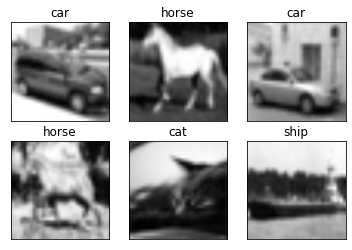

In [ ]:
#3 View few images from test data 
# loading one set of test data batch 
sample = enumerate(testloader)
batch_id, (sample_data, sample_targets) = next(sample)

#shape of one test data batch 
print('Shape of data',sample_data.shape)

fig = plt.figure()
# Viewing 6 images from loaded test data batch
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(sample_data[i][0],cmap='gray')
  plt.title("{}".format(classes[sample_targets[i]]))
  plt.xticks([])
  plt.yticks([])


In [ ]:
#pretrained on the 1000-class Imagenet dataset
model = models.resnet18(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
#pretrained on the 1000-class Imagenet dataset
#model = models.resnet18(pretrained=True)

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False

n_inputs = model.fc.in_features
model.fc = nn.Sequential(
                      nn.Linear(n_inputs, 256), 
                      nn.Linear(256, 10))



Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)


cuda


In [ ]:
model = model.to(device)
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
## list to hold loss and accuracy for train and test
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device,criterion, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        
            # get samples
            data, target = data.to(device), target.to(device)

            # Init
            optimizer.zero_grad()
            # Predict
            y_pred = model(data)

            # Calculate loss
            loss = criterion(y_pred, target)
            train_losses.append(loss)

            # Backpropagation
            loss.backward()
            optimizer.step()

            
            pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            processed += len(data)
            
            # Update pbar-tqdm
            pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
            train_acc.append(100*correct/processed)

def test(model, device,criterion, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss +=criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
       
    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9)

EPOCHS = 5

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device,criterion,trainloader, optimizer, epoch)
    test(model, device,criterion,testloader)

  0%|          | 0/250 [00:00<?, ?it/s]

cuda
EPOCH: 0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.6637226939201355 Batch_id=249 Accuracy=73.24: 100%|██████████| 250/250 [01:24<00:00,  2.97it/s]
  0%|          | 0/250 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 7922/10000 (79.22%)

EPOCH: 1


Loss=0.5522749423980713 Batch_id=249 Accuracy=79.61: 100%|██████████| 250/250 [01:24<00:00,  2.97it/s]
  0%|          | 0/250 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 7933/10000 (79.33%)

EPOCH: 2


Loss=0.5027223825454712 Batch_id=249 Accuracy=80.31: 100%|██████████| 250/250 [01:23<00:00,  2.99it/s]
  0%|          | 0/250 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8064/10000 (80.64%)

EPOCH: 3


Loss=0.5809068083763123 Batch_id=249 Accuracy=80.63: 100%|██████████| 250/250 [01:23<00:00,  3.01it/s]
  0%|          | 0/250 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 7953/10000 (79.53%)

EPOCH: 4


Loss=0.5431015491485596 Batch_id=249 Accuracy=81.23: 100%|██████████| 250/250 [01:23<00:00,  3.00it/s]



Test set: Average loss: 0.0028, Accuracy: 8073/10000 (80.73%)

